### Este código consiste en la creación de nuevas features del dataset original sin quitar ninguna existente. Una vez se obtenga el modelo se predecirá junio y se usará el feature importance para reducir el dataset en una nueva notebook

In [1]:
# Import liberías
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score


In [2]:
#leo el csv
df = pd.read_csv('C:/Users/Lucas/Downloads/Maestria/EyF/competencia_01_crudo.csv')

In [3]:

# calculo el periodo0 consecutivo
dsimple = df.copy()
dsimple["pos"] = range(1, len(dsimple) + 1)
dsimple["periodo0"] = (dsimple["foto_mes"] // 100) * 12 + (dsimple["foto_mes"] % 100)

# ordeno
dsimple = dsimple.sort_values(by=["numero_de_cliente", "periodo0"])

# calculo topes
periodo_ultimo = dsimple["periodo0"].max()
periodo_anteultimo = periodo_ultimo - 1

# calculo los leads de orden 1 y 2 (shift con signo negativo equivale a lead en R)
dsimple["periodo1"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-1)
dsimple["periodo2"] = dsimple.groupby("numero_de_cliente")["periodo0"].shift(-2)

# asigno valores por defecto
dsimple["clase_ternaria"] = None
dsimple.loc[dsimple["periodo0"] < periodo_anteultimo, "clase_ternaria"] = "CONTINUA"

# calculo BAJA+1
cond_baja1 = (
    (dsimple["periodo0"] < periodo_ultimo)
    & (dsimple["periodo1"].isna() | (dsimple["periodo0"] + 1 < dsimple["periodo1"]))
)
dsimple.loc[cond_baja1, "clase_ternaria"] = "BAJA+1"

# calculo BAJA+2
cond_baja2 = (
    (dsimple["periodo0"] < periodo_anteultimo)
    & (dsimple["periodo0"] + 1 == dsimple["periodo1"])
    & (dsimple["periodo2"].isna() | (dsimple["periodo0"] + 2 < dsimple["periodo2"]))
)
dsimple.loc[cond_baja2, "clase_ternaria"] = "BAJA+2"

# vuelvo a ordenar por pos y pego al dataset original
dsimple = dsimple.sort_values(by="pos")
df["clase_ternaria"] = dsimple["clase_ternaria"].values

In [4]:
# ordeno
df = df.sort_values(by=["foto_mes", "clase_ternaria", "numero_de_cliente"])

# contar registros por foto_mes y clase_ternaria
conteos = df.groupby(["foto_mes", "clase_ternaria"]).size().reset_index(name="N")

# parámetros

PARAM = {
    "experimento": 4940,
    "semilla_primigenia": [878787],
    "train": [202101,202102, 202103],
    "train_final": [202101, 202102, 202103,202104],
    "future": [202106],
    "semilla_kaggle": 314159,
    "cortes": list(range(6000, 19001, 500)),
    "trainingstrategy": {
        "undersampling": 0.2
    }
}




In [5]:
import lightgbm as lgb

#Defino los hiperparámetros fijos y aquellos que voy a optimizar

# cross validation folds
PARAM["hyperparametertuning"] = {}
PARAM["hyperparametertuning"]["xval_folds"] = 5



# parámetros fijos de LightGBM
PARAM["lgbm"] = {}
PARAM["lgbm"]["param_fijos"] = {
    "boosting_type": "gbdt",  # en python el nombre es boosting_type
    "objective": "binary",
    "metric": "auc",
    "first_metric_only": False,
    "boost_from_average": True,
    "feature_pre_filter": False,
    "force_row_wise": True,
    "verbosity": -100,

    "seed": PARAM["semilla_primigenia"],

    "max_depth": -1,
    "min_gain_to_split": 0.0,
    "min_sum_hessian_in_leaf": 0.001,
    "lambda_l1": 0.0,
    "lambda_l2": 0.0,
    "max_bin": 31,

    "bagging_fraction": 1.0,
    "pos_bagging_fraction": 1.0,
    "neg_bagging_fraction": 1.0,
    "is_unbalance": False,
    "scale_pos_weight": 1.0,

    "drop_rate": 0.1,
    "max_drop": 50,
    "skip_drop": 0.5,

    "extra_trees": False,

    "num_iterations": 1200,
    "learning_rate": 0.02,
    "feature_fraction": 0.5,
    "num_leaves": 750,
    "min_data_in_leaf": 5000,
}

# rango de hiperparámetros 
PARAM["hyperparametertuning"]["hs"] = {
    # hiperparámetros clásicos
    "num_iterations": {"type": "int", "low": 500, "high": 2300},
    "learning_rate": {"type": "float", "low": 0.01, "high": 0.3},
    "feature_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "num_leaves": {"type": "int", "low": 8, "high": 2200},
    "min_data_in_leaf": {"type": "int", "low": 1, "high": 3500},

    # nuevos hiperparámetros
    "max_depth": {"type": "int", "low": -1, "high": 18},
    "lambda_l1": {"type": "float", "low": 0.0, "high": 15.0},
    "lambda_l2": {"type": "float", "low": 0.0, "high": 25.0},
    "min_gain_to_split": {"type": "float", "low": 0.0, "high": 10.0},
    "bagging_fraction": {"type": "float", "low": 0.4, "high": 1.0},
    "bagging_freq": {"type": "int", "low": 0, "high": 10},
    "min_sum_hessian_in_leaf": {"type": "float", "low": 0.001, "high": 30.0},
}





#### Defino las funciones particionar, realidad_inicializar y realidad evaluar

In [6]:
from sklearn.model_selection import train_test_split

def particionar(data, division, agrupa="", campo="fold", start=1, seed=None):
    data = data.copy().reset_index(drop=True)  # 🔹 reset indices
    total = sum(division)
    fracs = [d / total for d in division]  # pasar a proporciones
    bloques = list(range(start, start + len(division)))

    if agrupa:
        strat_col = data[agrupa]
    else:
        strat_col = None

    folds = np.zeros(len(data), dtype=int)
    idx = np.arange(len(data))

    for i, frac in enumerate(fracs):
        if i == len(fracs) - 1:
            chosen_idx = idx
        else:
            _, chosen_idx = train_test_split(
                idx,
                test_size=1-frac,
                stratify=strat_col.iloc[idx] if strat_col is not None else None,
                random_state=seed
            )
        folds[chosen_idx] = bloques[i]
        # actualizar lo que queda
        mask = np.isin(idx, chosen_idx, invert=True)
        idx = idx[mask]

    data[campo] = folds
    return data



In [7]:
def realidad_inicializar(pfuture, pparam):
    # datos para verificar la ganancia
    drealidad = pfuture[["numero_de_cliente", "foto_mes", "clase_ternaria"]].copy()

    drealidad = particionar(
        drealidad,
        division=[3, 7],
        agrupa="clase_ternaria",
        seed=PARAM["semilla_kaggle"]
    )
    return drealidad


In [8]:
def realidad_evaluar(prealidad, pprediccion):
    """
    Calcula la ganancia esperada.
    prealidad: DataFrame con columnas [numero_de_cliente, foto_mes, clase_ternaria, fold]
    pprediccion: DataFrame con columnas [numero_de_cliente, foto_mes, Predicted]
    """
    # merge para agregar predicciones
    merged = prealidad.merge(
        pprediccion[["numero_de_cliente", "foto_mes", "Predicted"]],
        on=["numero_de_cliente", "foto_mes"],
        how="left"
    )
    merged["predicted"] = merged["Predicted"].astype("Int64")
    merged = merged.drop(columns="Predicted")

    # tabla de conteos
    tbl = (
        merged.groupby(["fold", "predicted", "clase_ternaria"])
        .size()
        .reset_index(name="qty")
    )

    # función de ganancia
    def ganancia(subtbl):
        return (subtbl["qty"] * np.where(subtbl["clase_ternaria"]=="BAJA+2", 780000, -20000)).sum()

    res = {}
    # fold==1 → public (dividido por 0.3)
    mask_pub = (tbl["fold"]==1) & (tbl["predicted"]==1)
    res["public"] = ganancia(tbl[mask_pub]) / 0.3

    # fold==2 → private (dividido por 0.7)
    mask_priv = (tbl["fold"]==2) & (tbl["predicted"]==1)
    res["private"] = ganancia(tbl[mask_priv]) / 0.7

    # total sin dividir
    mask_total = tbl["predicted"]==1
    res["total"] = ganancia(tbl[mask_total])

    return res


#### "Normalizo" la columna mpayroll de junio multiplicando por 0,7 el valor para aquellos casos donde cobre aguinaldo el cliente.

In [9]:
# Aseguramos que la columna mpayroll sea numérica
df["mpayroll"] = pd.to_numeric(df["mpayroll"], errors="coerce")

# 1️⃣ Crear una máscara de clientes que tienen mpayroll no nulo en 202105 y 202106
clientes_validos = df.query("foto_mes in [202105, 202106]") \
    .pivot(index="numero_de_cliente", columns="foto_mes", values="mpayroll") \
    .dropna(subset=[202105, 202106]) \
    .index

# 2️⃣ Copiar mpayroll a una nueva columna
df["mpayroll_norm"] = df["mpayroll"]

# 3️⃣ Aplicar la normalización (multiplicar por 0.7 solo en 202106 y clientes válidos)
mask = (df["foto_mes"] == 202106) & (df["numero_de_cliente"].isin(clientes_validos))
df.loc[mask, "mpayroll_norm"] = df.loc[mask, "mpayroll"] * 0.7

#### Armo rankings de las columnas monetarias

In [10]:
import numpy as np
import pandas as pd

def rank_separate_group(df, columns, group_col="foto_mes"):
    """
    Genera columnas *_ranked por cada variable monetaria,
    aplicando ranking separado por signo y por grupo temporal (foto_mes),
    tolerante a NaN.
    """
    df = df.copy()

    for col in columns:
        new_col = f"{col}_ranked"
        df[new_col] = np.nan  # inicializa la columna

        def rank_group(g):
            s = g[col]
            ranked = pd.Series(index=s.index, dtype=float)

            # negativos
            mask_neg = (s < 0) & s.notna()
            if mask_neg.any():
                ranked.loc[mask_neg] = -s[mask_neg].rank(method="average", ascending=False)

            # positivos
            mask_pos = (s > 0) & s.notna()
            if mask_pos.any():
                ranked.loc[mask_pos] = s[mask_pos].rank(method="average", ascending=True)

            # ceros
            mask_zero = (s == 0) & s.notna()
            if mask_zero.any():
                ranked.loc[mask_zero] = 0

            return ranked

        # aplicar ranking solo a filas válidas del grupo
        ranked_series = df.groupby(group_col, group_keys=False).apply(rank_group)
        df.loc[ranked_series.index, new_col] = ranked_series

    return df


cols_monetarias = [
    "mrentabilidad", "mrentabilidad_annual", "mcomisiones", "mactivos_margen", "mpasivos_margen", 
    "mcuenta_corriente_adicional", "mcuenta_corriente", "mcaja_ahorro", "mcaja_ahorro_adicional", 
    "mcaja_ahorro_dolares", "mcuentas_saldo", "mautoservicio", "mtarjeta_visa_consumo", "mtarjeta_master_consumo", 
    "mprestamos_personales", "mprestamos_prendarios", "mprestamos_hipotecarios", "mplazo_fijo_dolares", 
    "mplazo_fijo_pesos", "minversion1_pesos", "minversion1_dolares", "minversion2", "mpayroll", "mpayroll2", 
    "mcuenta_debitos_automaticos", "mttarjeta_visa_debitos_automaticos", "mttarjeta_master_debitos_automaticos", 
    "mpagodeservicios", "mpagomiscuentas", "mcajeros_propios_descuentos", "mtarjeta_visa_descuentos", 
    "mtarjeta_master_descuentos", "mcomisiones_mantenimiento", "mcomisiones_otras", "mforex_buy", "mforex_sell", 
    "mtransferencias_recibidas", "mtransferencias_emitidas", "mextraccion_autoservicio", "mcheques_depositados", 
    "mcheques_emitidos", "mcheques_depositados_rechazados", "mcheques_emitidos_rechazados", "matm", "matm_other", 
    "Master_mfinanciacion_limite", "Master_msaldototal", "Master_msaldopesos", "Master_msaldodolares", 
    "Master_mconsumospesos", "Master_mconsumosdolares", "Master_mlimitecompra", "Master_madelantopesos", 
    "Master_madelantodolares", "Master_mpagado", "Master_mpagospesos", "Master_mpagosdolares", 
    "Master_mconsumototal", "Master_mpagominimo", "Visa_mfinanciacion_limite", "Visa_msaldototal", 
    "Visa_msaldopesos", "Visa_msaldodolares", "Visa_mconsumospesos", "Visa_mconsumosdolares", 
    "Visa_mlimitecompra", "Visa_madelantopesos", "Visa_madelantodolares", "Visa_mpagado", "Visa_mpagospesos", 
    "Visa_mpagosdolares", "Visa_mconsumototal", "Visa_mpagominimo","mpayroll_norm"
]

# aplicar ranking neutralizado por mes
df = rank_separate_group(df, cols_monetarias)

#### Hago columnas con lag y delta lag de orden 1 y 2 de todas las columnas salvo numero de cliente, foto mes y clase ternaria.

In [ ]:
# --- 0️⃣ Preparación ---
df = df.sort_values(["numero_de_cliente", "foto_mes"])

# columnas a excluir
excluir = {"numero_de_cliente", "foto_mes", "clase_ternaria"}
columnas = [c for c in df.columns if c not in excluir]

# --- 1️⃣ Generar lag y delta de orden 1 y 2 ---
for col in columnas:
    for lag in [1, 2]:
        df[f"{col}_lag{lag}"] = df.groupby("numero_de_cliente")[col].shift(lag)
        df[f"{col}_delta{lag}"] = df[col] - df[f"{col}_lag{lag}"]

#### Genero el dataset train a partir de los meses seleccionados al inicio

In [15]:
# 1️⃣ Filtrar por meses de training
dataset_train = df[df["foto_mes"].isin(PARAM["train"])].copy()

# 2️⃣ Clase binaria
dataset_train["clase01"] = np.where(
    dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)

# 3️⃣ Undersampling de CONTINUA
np.random.seed(PARAM["semilla_primigenia"][0])  # recordá que es lista
dataset_train["azar"] = np.random.rand(len(dataset_train))
mask_training = (
    (dataset_train["foto_mes"].isin(PARAM["train"])) &
    ((dataset_train["azar"] <= PARAM["trainingstrategy"]["undersampling"]) |
     (dataset_train["clase_ternaria"].isin(["BAJA+1", "BAJA+2"])))
)
dataset_train = dataset_train.loc[mask_training].copy()

# 4️⃣ Seleccionar columnas a usar
campos_buenos = dataset_train.columns.difference(
    ["clase_ternaria", "clase01", "azar"]
)

X_train = dataset_train[campos_buenos].copy()
y_train = dataset_train["clase01"].copy()

# 5️⃣ Convertir categóricas a numéricas si las hay
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category').cat.codes

# 6️⃣ Asegurar tipos correctos para LightGBM
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)

# ✅ Listo para usar en Optuna
print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Balance clases:\n", y_train.value_counts())



Shape X_train: (101496, 1137)
Shape y_train: (101496,)
Balance clases:
 clase01
0    96196
1     5300
Name: count, dtype: int64


##### Genero la función de estimar ganancia

In [13]:
import optuna
from sklearn.model_selection import StratifiedKFold

# Semilla
seed = 878787
seeds = [seed]

# Función de Optuna para estimar AUC con CV
def EstimarGanancia_AUC_lightgbm(trial, X, y, seeds):
    aucs_semillas = []

    for seed in seeds:
        param = {
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "seed": seed,

            "num_iterations": trial.suggest_int("num_iterations", 10, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 8, 2200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "max_depth": trial.suggest_int("max_depth", -1, 18),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 1500),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 15.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 15.0),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 10.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.001, 30.0),
        }


        cv = StratifiedKFold(
            n_splits=PARAM["hyperparametertuning"]["xval_folds"],
            shuffle=True,
            random_state=seed
        )

        aucs = []
        for train_idx, valid_idx in cv.split(X, y):
            lgb_train = lgb.Dataset(X.iloc[train_idx].astype(np.float32), label=y.iloc[train_idx].astype(np.int32))
            lgb_valid = lgb.Dataset(X.iloc[valid_idx].astype(np.float32), label=y.iloc[valid_idx].astype(np.int32))

            model = lgb.train(
                param,
                lgb_train,
                valid_sets=[lgb_valid],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
            )
            preds = model.predict(X.iloc[valid_idx])
            auc = roc_auc_score(y.iloc[valid_idx], preds)
            aucs.append(auc)

        aucs_semillas.append(np.mean(aucs))

    return np.mean(aucs_semillas)



C:\Users\Lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Busco hiperparámetros con BO usando optune, primero con 20 pruebas random y luego 30 con TPESampler

In [14]:
# Creo study
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.RandomSampler(seed=seed)
)

# Primeras 20 pruebas random
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=20
)

# Luego 30 pruebas con TPE
study.sampler = optuna.samplers.TPESampler(seed=seed)
study.optimize(
    lambda trial: EstimarGanancia_AUC_lightgbm(trial, X_train, y_train, seeds),
    n_trials=30
)

# Guardo resultados
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state")).rename(columns={"value": "AUC"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana.sort_values(by="AUC", ascending=False).to_csv("BO_log.txt", sep="\t", index=False)

PARAM["out"] = {
    "lgbm": {
        "mejores_hiperparametros": study.best_trial.params,
        "AUC": study.best_trial.value
    }
}
print("✅ Mejores hiperparámetros:", study.best_trial.params)
print("✅ Mejor AUC:", study.best_trial.value)




[I 2025-10-09 14:11:05,251] A new study created in memory with name: no-name-99ffb806-a667-4396-8b83-1b0d2a95c0b2


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.926931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.931684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.918345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's auc: 0.928025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's auc: 0.930819


[I 2025-10-09 14:11:59,985] Trial 0 finished with value: 0.9271521923606498 and parameters: {'num_iterations': 1180, 'learning_rate': 0.15069190115899878, 'num_leaves': 1159, 'feature_fraction': 0.6322520900294102, 'max_depth': 13, 'min_data_in_leaf': 369, 'lambda_l1': 8.057777905404162, 'lambda_l2': 6.986052108818572, 'min_gain_to_split': 7.576146557315888, 'bagging_fraction': 0.8234966468376737, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 22.48711155004957}. Best is trial 0 with value: 0.9271521923606498.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[407]	valid_0's auc: 0.927658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[471]	valid_0's auc: 0.932778
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[440]	valid_0's auc: 0.919484
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	valid_0's auc: 0.92919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's auc: 0.930954


[I 2025-10-09 14:14:45,033] Trial 1 finished with value: 0.9280122989418154 and parameters: {'num_iterations': 610, 'learning_rate': 0.020694043835740385, 'num_leaves': 1139, 'feature_fraction': 0.8506907346287693, 'max_depth': 8, 'min_data_in_leaf': 1024, 'lambda_l1': 3.9047355824451495, 'lambda_l2': 10.351260083536108, 'min_gain_to_split': 8.702244207027077, 'bagging_fraction': 0.7289920139767798, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 2.295948035507634}. Best is trial 1 with value: 0.9280122989418154.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.924436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.932884
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.919229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.92765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.930941


[I 2025-10-09 14:15:38,581] Trial 2 finished with value: 0.9270222297854989 and parameters: {'num_iterations': 1227, 'learning_rate': 0.24687177900394722, 'num_leaves': 1479, 'feature_fraction': 0.8599079405644661, 'max_depth': 0, 'min_data_in_leaf': 762, 'lambda_l1': 12.526566500758413, 'lambda_l2': 3.8158431151474237, 'min_gain_to_split': 1.7063557011120112, 'bagging_fraction': 0.5234372974027808, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 22.081505226336855}. Best is trial 1 with value: 0.9280122989418154.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's auc: 0.9289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's auc: 0.933716
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.920483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.930967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.932929


[I 2025-10-09 14:16:45,475] Trial 3 finished with value: 0.9293991358554734 and parameters: {'num_iterations': 890, 'learning_rate': 0.09908863657922856, 'num_leaves': 1784, 'feature_fraction': 0.9185553665761836, 'max_depth': 4, 'min_data_in_leaf': 855, 'lambda_l1': 1.6100680405575307, 'lambda_l2': 14.479197814321314, 'min_gain_to_split': 7.337028251201226, 'bagging_fraction': 0.867562169662011, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 0.21185511591588305}. Best is trial 3 with value: 0.9293991358554734.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[811]	valid_0's auc: 0.928417
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[811]	valid_0's auc: 0.933812
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[808]	valid_0's auc: 0.920713
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[811]	valid_0's auc: 0.929238
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[809]	valid_0's auc: 0.932035


[I 2025-10-09 14:19:52,563] Trial 4 finished with value: 0.9288429544006261 and parameters: {'num_iterations': 811, 'learning_rate': 0.011130434324723907, 'num_leaves': 500, 'feature_fraction': 0.7879631482476517, 'max_depth': 9, 'min_data_in_leaf': 1472, 'lambda_l1': 14.383692475328225, 'lambda_l2': 2.279486193293319, 'min_gain_to_split': 2.5249887126261115, 'bagging_fraction': 0.8212751221088193, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 16.768329081900088}. Best is trial 3 with value: 0.9293991358554734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.92796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's auc: 0.933646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.920306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.929957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.931582


[I 2025-10-09 14:20:42,251] Trial 5 finished with value: 0.928668197095529 and parameters: {'num_iterations': 1573, 'learning_rate': 0.25218915640296996, 'num_leaves': 1857, 'feature_fraction': 0.6472361351289007, 'max_depth': 16, 'min_data_in_leaf': 339, 'lambda_l1': 12.424387376628198, 'lambda_l2': 11.771994344417509, 'min_gain_to_split': 3.3175274050499737, 'bagging_fraction': 0.8606159362039743, 'bagging_freq': 2, 'min_sum_hessian_in_leaf': 24.290226873509415}. Best is trial 3 with value: 0.9293991358554734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.918663
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.924787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.910291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.921508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.925311


[I 2025-10-09 14:21:28,001] Trial 6 finished with value: 0.9200967003689989 and parameters: {'num_iterations': 1213, 'learning_rate': 0.2891684534135509, 'num_leaves': 673, 'feature_fraction': 0.4242177341316495, 'max_depth': 1, 'min_data_in_leaf': 712, 'lambda_l1': 14.330494768522627, 'lambda_l2': 1.4020059084903207, 'min_gain_to_split': 7.931654854989237, 'bagging_fraction': 0.4930132759087307, 'bagging_freq': 9, 'min_sum_hessian_in_leaf': 11.853025209348305}. Best is trial 3 with value: 0.9293991358554734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.926765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.930427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.91813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.927137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.930892


[I 2025-10-09 14:22:19,684] Trial 7 finished with value: 0.9266699631300792 and parameters: {'num_iterations': 699, 'learning_rate': 0.22521398336772672, 'num_leaves': 2044, 'feature_fraction': 0.9121003637601469, 'max_depth': 14, 'min_data_in_leaf': 62, 'lambda_l1': 1.4440721990250727, 'lambda_l2': 2.663951966537141, 'min_gain_to_split': 9.069713019445732, 'bagging_fraction': 0.7617371682060123, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 0.482692063733405}. Best is trial 3 with value: 0.9293991358554734.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[279]	valid_0's auc: 0.929228
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's auc: 0.934219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[364]	valid_0's auc: 0.921152
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[339]	valid_0's auc: 0.931003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's auc: 0.932502


[I 2025-10-09 14:23:43,708] Trial 8 finished with value: 0.9296207783372132 and parameters: {'num_iterations': 1677, 'learning_rate': 0.03765086232463476, 'num_leaves': 818, 'feature_fraction': 0.743827369384561, 'max_depth': 5, 'min_data_in_leaf': 126, 'lambda_l1': 10.45351382900559, 'lambda_l2': 11.647786878397698, 'min_gain_to_split': 4.399890365086526, 'bagging_fraction': 0.6277518758546545, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 12.71208965596918}. Best is trial 8 with value: 0.9296207783372132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	valid_0's auc: 0.925326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[473]	valid_0's auc: 0.932464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's auc: 0.916904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[482]	valid_0's auc: 0.928569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[492]	valid_0's auc: 0.932711


[I 2025-10-09 14:25:17,964] Trial 9 finished with value: 0.9271894417924468 and parameters: {'num_iterations': 1265, 'learning_rate': 0.2514414300644576, 'num_leaves': 123, 'feature_fraction': 0.7390701929809338, 'max_depth': 1, 'min_data_in_leaf': 1022, 'lambda_l1': 13.672301941715478, 'lambda_l2': 5.774251194632502, 'min_gain_to_split': 1.6482961060418844, 'bagging_fraction': 0.9388821996441759, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 24.41849743241833}. Best is trial 8 with value: 0.9296207783372132.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's auc: 0.925581
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's auc: 0.930018
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's auc: 0.916596
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's auc: 0.92729
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's auc: 0.930213


[I 2025-10-09 14:26:03,991] Trial 10 finished with value: 0.925939516374498 and parameters: {'num_iterations': 54, 'learning_rate': 0.24624819393809175, 'num_leaves': 1714, 'feature_fraction': 0.896461540212959, 'max_depth': 14, 'min_data_in_leaf': 1361, 'lambda_l1': 7.881559924666472, 'lambda_l2': 10.32370138223586, 'min_gain_to_split': 7.131497235673578, 'bagging_fraction': 0.8122864692777264, 'bagging_freq': 9, 'min_sum_hessian_in_leaf': 16.008064364661312}. Best is trial 8 with value: 0.9296207783372132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.928184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's auc: 0.933055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[277]	valid_0's auc: 0.920551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[225]	valid_0's auc: 0.929469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[233]	valid_0's auc: 0.932098


[I 2025-10-09 14:27:13,123] Trial 11 finished with value: 0.9286716214682451 and parameters: {'num_iterations': 740, 'learning_rate': 0.05734521650223409, 'num_leaves': 1001, 'feature_fraction': 0.7070070542698941, 'max_depth': 13, 'min_data_in_leaf': 682, 'lambda_l1': 13.357125614873992, 'lambda_l2': 6.61931535112611, 'min_gain_to_split': 3.3491512791231495, 'bagging_fraction': 0.570811834544851, 'bagging_freq': 4, 'min_sum_hessian_in_leaf': 17.94704337448833}. Best is trial 8 with value: 0.9296207783372132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.928043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's auc: 0.932927
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.921946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's auc: 0.930563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[83]	valid_0's auc: 0.933782


[I 2025-10-09 14:28:10,060] Trial 12 finished with value: 0.9294145909882543 and parameters: {'num_iterations': 1086, 'learning_rate': 0.27167455137451274, 'num_leaves': 2072, 'feature_fraction': 0.6045164404046405, 'max_depth': 9, 'min_data_in_leaf': 528, 'lambda_l1': 8.298925854042775, 'lambda_l2': 13.925831731730394, 'min_gain_to_split': 3.3814897136227717, 'bagging_fraction': 0.6610100308979779, 'bagging_freq': 1, 'min_sum_hessian_in_leaf': 2.328432063653495}. Best is trial 8 with value: 0.9296207783372132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's auc: 0.929844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[304]	valid_0's auc: 0.93329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's auc: 0.921499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's auc: 0.930781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	valid_0's auc: 0.93312


[I 2025-10-09 14:29:52,969] Trial 13 finished with value: 0.9297069176990412 and parameters: {'num_iterations': 1722, 'learning_rate': 0.027082296248414524, 'num_leaves': 1170, 'feature_fraction': 0.9411513643524648, 'max_depth': 6, 'min_data_in_leaf': 541, 'lambda_l1': 8.113172705739558, 'lambda_l2': 2.7462747556696816, 'min_gain_to_split': 6.235799690670218, 'bagging_fraction': 0.907593977727425, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 2.672928295940005}. Best is trial 13 with value: 0.9297069176990412.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[122]	valid_0's auc: 0.928751
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[126]	valid_0's auc: 0.932707
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[126]	valid_0's auc: 0.920263
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[126]	valid_0's auc: 0.929401
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[125]	valid_0's auc: 0.931693


[I 2025-10-09 14:30:50,219] Trial 14 finished with value: 0.928563158595607 and parameters: {'num_iterations': 126, 'learning_rate': 0.06590608662981458, 'num_leaves': 12, 'feature_fraction': 0.9434327601296862, 'max_depth': 13, 'min_data_in_leaf': 258, 'lambda_l1': 6.392651742810374, 'lambda_l2': 3.761229842858694, 'min_gain_to_split': 1.381638821197857, 'bagging_fraction': 0.5790716187630999, 'bagging_freq': 4, 'min_sum_hessian_in_leaf': 26.804816680962308}. Best is trial 13 with value: 0.9297069176990412.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	valid_0's auc: 0.926634
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.93196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.919574
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.927954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.93045


[I 2025-10-09 14:31:41,059] Trial 15 finished with value: 0.927292864178354 and parameters: {'num_iterations': 1537, 'learning_rate': 0.09691992277276358, 'num_leaves': 964, 'feature_fraction': 0.5536703976238684, 'max_depth': 12, 'min_data_in_leaf': 1073, 'lambda_l1': 1.5671547286549325, 'lambda_l2': 5.4731965251337105, 'min_gain_to_split': 9.47060160110527, 'bagging_fraction': 0.7884813252110626, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 25.990051440133012}. Best is trial 13 with value: 0.9297069176990412.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[170]	valid_0's auc: 0.930483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's auc: 0.934336
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	valid_0's auc: 0.922516
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's auc: 0.932316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	valid_0's auc: 0.933804


[I 2025-10-09 14:32:43,024] Trial 16 finished with value: 0.9306908989704062 and parameters: {'num_iterations': 302, 'learning_rate': 0.11091139092373707, 'num_leaves': 892, 'feature_fraction': 0.9585878342224831, 'max_depth': 12, 'min_data_in_leaf': 523, 'lambda_l1': 14.829959331010729, 'lambda_l2': 14.402888742799796, 'min_gain_to_split': 1.8519920348165275, 'bagging_fraction': 0.646736517774646, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 12.181838894111204}. Best is trial 16 with value: 0.9306908989704062.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.924304
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's auc: 0.933335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.921031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.927764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's auc: 0.932545


[I 2025-10-09 14:33:28,989] Trial 17 finished with value: 0.9277956895552733 and parameters: {'num_iterations': 1746, 'learning_rate': 0.26574591151189964, 'num_leaves': 69, 'feature_fraction': 0.9367126677788017, 'max_depth': 17, 'min_data_in_leaf': 942, 'lambda_l1': 0.25108309306789867, 'lambda_l2': 0.16573963392286506, 'min_gain_to_split': 3.4408788314770633, 'bagging_fraction': 0.6089721087759206, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 0.867803254082599}. Best is trial 16 with value: 0.9306908989704062.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	valid_0's auc: 0.924672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[417]	valid_0's auc: 0.932946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[534]	valid_0's auc: 0.917933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[338]	valid_0's auc: 0.928587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[445]	valid_0's auc: 0.931622


[I 2025-10-09 14:34:53,908] Trial 18 finished with value: 0.9271519069282508 and parameters: {'num_iterations': 1820, 'learning_rate': 0.20847118159844905, 'num_leaves': 1228, 'feature_fraction': 0.9819878900428428, 'max_depth': 1, 'min_data_in_leaf': 259, 'lambda_l1': 3.704622287461202, 'lambda_l2': 13.017209034364567, 'min_gain_to_split': 2.091105807060043, 'bagging_fraction': 0.5238939245593125, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 26.11920828882985}. Best is trial 16 with value: 0.9306908989704062.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.926816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.931388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's auc: 0.918334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's auc: 0.928703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's auc: 0.931197


[I 2025-10-09 14:35:45,158] Trial 19 finished with value: 0.9272877132896147 and parameters: {'num_iterations': 584, 'learning_rate': 0.08775256703514342, 'num_leaves': 682, 'feature_fraction': 0.5974005260560606, 'max_depth': 4, 'min_data_in_leaf': 571, 'lambda_l1': 2.1684511472367713, 'lambda_l2': 6.210750298686233, 'min_gain_to_split': 9.413572666666763, 'bagging_fraction': 0.6288283664863297, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 25.044165476287894}. Best is trial 16 with value: 0.9306908989704062.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.932811
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[306]	valid_0's auc: 0.941289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.928926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.933826
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[226]	valid_0's auc: 0.939233


[I 2025-10-09 14:37:48,122] Trial 20 finished with value: 0.9352171367702047 and parameters: {'num_iterations': 328, 'learning_rate': 0.14148630707550516, 'num_leaves': 1414, 'feature_fraction': 0.9875433065616599, 'max_depth': 7, 'min_data_in_leaf': 493, 'lambda_l1': 10.247614031512086, 'lambda_l2': 9.070048893987414, 'min_gain_to_split': 0.048902496199919376, 'bagging_fraction': 0.9888299137414693, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.471289490776165}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's auc: 0.934467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[237]	valid_0's auc: 0.940359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's auc: 0.927965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.933337
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[351]	valid_0's auc: 0.939529


[I 2025-10-09 14:40:12,561] Trial 21 finished with value: 0.9351312483896871 and parameters: {'num_iterations': 361, 'learning_rate': 0.13775019388531756, 'num_leaves': 1455, 'feature_fraction': 0.9909289429188364, 'max_depth': 7, 'min_data_in_leaf': 496, 'lambda_l1': 10.36927339301408, 'lambda_l2': 8.949074857818111, 'min_gain_to_split': 0.00738348879646189, 'bagging_fraction': 0.9963188790238322, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.893657302298395}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.933198
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[199]	valid_0's auc: 0.939544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	valid_0's auc: 0.928721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's auc: 0.934087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.937668


[I 2025-10-09 14:41:54,299] Trial 22 finished with value: 0.9346436612136635 and parameters: {'num_iterations': 341, 'learning_rate': 0.15674783297318579, 'num_leaves': 1456, 'feature_fraction': 0.992314440560798, 'max_depth': 11, 'min_data_in_leaf': 464, 'lambda_l1': 10.54868695685168, 'lambda_l2': 8.922250694253982, 'min_gain_to_split': 0.12960033974066054, 'bagging_fraction': 0.9809824846628696, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 7.4635749280652846}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[153]	valid_0's auc: 0.932154
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.938771
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.928226
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.934332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's auc: 0.937639


[I 2025-10-09 14:43:22,871] Trial 23 finished with value: 0.934224515620216 and parameters: {'num_iterations': 377, 'learning_rate': 0.1602012317301575, 'num_leaves': 1522, 'feature_fraction': 0.9988153983605003, 'max_depth': 10, 'min_data_in_leaf': 413, 'lambda_l1': 10.119600599314328, 'lambda_l2': 8.881250681693835, 'min_gain_to_split': 0.2613193706263339, 'bagging_fraction': 0.9808030111087076, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.672144665377505}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.93279
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[223]	valid_0's auc: 0.940147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[246]	valid_0's auc: 0.92898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.934009
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.938193


[I 2025-10-09 14:45:03,751] Trial 24 finished with value: 0.9348237928873224 and parameters: {'num_iterations': 406, 'learning_rate': 0.15373356079981018, 'num_leaves': 1369, 'feature_fraction': 0.8261245422719168, 'max_depth': 7, 'min_data_in_leaf': 220, 'lambda_l1': 10.450288447847596, 'lambda_l2': 8.395524465029425, 'min_gain_to_split': 0.038312061034643304, 'bagging_fraction': 0.993919652951368, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 7.951849759549634}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[169]	valid_0's auc: 0.93283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.938322
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.927345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.933758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[160]	valid_0's auc: 0.936705


[I 2025-10-09 14:46:13,803] Trial 25 finished with value: 0.933791896765278 and parameters: {'num_iterations': 469, 'learning_rate': 0.1281723474748134, 'num_leaves': 1356, 'feature_fraction': 0.8542634639106615, 'max_depth': 7, 'min_data_in_leaf': 2, 'lambda_l1': 9.318928870544603, 'lambda_l2': 8.983270875274913, 'min_gain_to_split': 0.7522414405522448, 'bagging_fraction': 0.9254214651494851, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.919985285653022}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[111]	valid_0's auc: 0.928766
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[160]	valid_0's auc: 0.934752
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's auc: 0.921295
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[156]	valid_0's auc: 0.930419
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[143]	valid_0's auc: 0.934109


[I 2025-10-09 14:47:01,466] Trial 26 finished with value: 0.9298680942695231 and parameters: {'num_iterations': 160, 'learning_rate': 0.19357753439987269, 'num_leaves': 1640, 'feature_fraction': 0.8182075424131399, 'max_depth': 3, 'min_data_in_leaf': 204, 'lambda_l1': 6.296917205498666, 'lambda_l2': 7.896623751875698, 'min_gain_to_split': 0.9199318558625768, 'bagging_fraction': 0.4215226954030178, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 9.186246039001857}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.931212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.936892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.925266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.93204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.936203


[I 2025-10-09 14:47:59,860] Trial 27 finished with value: 0.9323227378666632 and parameters: {'num_iterations': 196, 'learning_rate': 0.17675586740276325, 'num_leaves': 1327, 'feature_fraction': 0.8077376529289241, 'max_depth': 7, 'min_data_in_leaf': 631, 'lambda_l1': 11.230267918879896, 'lambda_l2': 10.856143382740752, 'min_gain_to_split': 0.680371323894233, 'bagging_fraction': 0.9938545193329472, 'bagging_freq': 9, 'min_sum_hessian_in_leaf': 5.0508436729009105}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[179]	valid_0's auc: 0.933193
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[219]	valid_0's auc: 0.939632
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.929399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[291]	valid_0's auc: 0.934173
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.937493


[I 2025-10-09 14:49:53,420] Trial 28 finished with value: 0.9347779404050967 and parameters: {'num_iterations': 511, 'learning_rate': 0.13211110719571134, 'num_leaves': 1593, 'feature_fraction': 0.8852219113216064, 'max_depth': 7, 'min_data_in_leaf': 344, 'lambda_l1': 11.60227010942576, 'lambda_l2': 7.959833387404664, 'min_gain_to_split': 0.04254701674426098, 'bagging_fraction': 0.8921875382386104, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 9.915017393650862}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.920115
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.921943
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.91014
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.919531
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's auc: 0.920676


[I 2025-10-09 14:50:33,261] Trial 29 finished with value: 0.9184810156457013 and parameters: {'num_iterations': 21, 'learning_rate': 0.13519228494517838, 'num_leaves': 1965, 'feature_fraction': 0.4947223730467968, 'max_depth': 3, 'min_data_in_leaf': 198, 'lambda_l1': 9.255568548194125, 'lambda_l2': 7.4150081610669005, 'min_gain_to_split': 5.1281979815210095, 'bagging_fraction': 0.9382798534467293, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 4.159458083041718}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.93035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.935022
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.922317
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.930528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's auc: 0.934855


[I 2025-10-09 14:51:31,630] Trial 30 finished with value: 0.9306143557515568 and parameters: {'num_iterations': 242, 'learning_rate': 0.17826938023658498, 'num_leaves': 2191, 'feature_fraction': 0.7816037482890598, 'max_depth': 6, 'min_data_in_leaf': 419, 'lambda_l1': 6.781929877859098, 'lambda_l2': 9.69575941853123, 'min_gain_to_split': 2.535457272945992, 'bagging_fraction': 0.999321375751208, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 9.242154923835038}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[258]	valid_0's auc: 0.933696
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's auc: 0.93962
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.927446
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.934204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[155]	valid_0's auc: 0.937305


[I 2025-10-09 14:53:46,734] Trial 31 finished with value: 0.934454094151018 and parameters: {'num_iterations': 500, 'learning_rate': 0.1333580434248985, 'num_leaves': 1650, 'feature_fraction': 0.8805992904017397, 'max_depth': 8, 'min_data_in_leaf': 330, 'lambda_l1': 12.092761221476497, 'lambda_l2': 7.663025404898079, 'min_gain_to_split': 0.008930685186055567, 'bagging_fraction': 0.8864473030781231, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 9.812521332630833}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[100]	valid_0's auc: 0.932228
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.938248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's auc: 0.925613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's auc: 0.931483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.936641


[I 2025-10-09 14:54:48,654] Trial 32 finished with value: 0.932842495032218 and parameters: {'num_iterations': 469, 'learning_rate': 0.14901280249638202, 'num_leaves': 1324, 'feature_fraction': 0.8347690997015286, 'max_depth': 7, 'min_data_in_leaf': 340, 'lambda_l1': 11.644133863313787, 'lambda_l2': 8.268428970318965, 'min_gain_to_split': 1.0176756531357087, 'bagging_fraction': 0.9502026467308309, 'bagging_freq': 4, 'min_sum_hessian_in_leaf': 4.961124003004242}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[214]	valid_0's auc: 0.931784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[310]	valid_0's auc: 0.937696
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.926064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.933631
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[263]	valid_0's auc: 0.936831


[I 2025-10-09 14:56:18,235] Trial 33 finished with value: 0.9332010676957033 and parameters: {'num_iterations': 633, 'learning_rate': 0.11762522537529892, 'num_leaves': 1568, 'feature_fraction': 0.8816522727552777, 'max_depth': 5, 'min_data_in_leaf': 128, 'lambda_l1': 10.983891397376313, 'lambda_l2': 4.981179329336612, 'min_gain_to_split': 0.5184556663512868, 'bagging_fraction': 0.9565143031259961, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 29.05313449657534}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's auc: 0.931321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's auc: 0.936038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	valid_0's auc: 0.923786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's auc: 0.931643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.935474


[I 2025-10-09 14:57:18,731] Trial 34 finished with value: 0.9316523217889362 and parameters: {'num_iterations': 415, 'learning_rate': 0.17337285351266601, 'num_leaves': 1086, 'feature_fraction': 0.9648863762920756, 'max_depth': 10, 'min_data_in_leaf': 842, 'lambda_l1': 9.725057866138036, 'lambda_l2': 9.863576788587958, 'min_gain_to_split': 1.2748076316011556, 'bagging_fraction': 0.8969823122769061, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 14.1067363584061}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's auc: 0.929064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's auc: 0.934363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's auc: 0.92138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.931004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's auc: 0.933578


[I 2025-10-09 14:58:15,049] Trial 35 finished with value: 0.9298780110730659 and parameters: {'num_iterations': 895, 'learning_rate': 0.1482352117775796, 'num_leaves': 1827, 'feature_fraction': 0.9191826536436631, 'max_depth': 8, 'min_data_in_leaf': 444, 'lambda_l1': 13.060398267748607, 'lambda_l2': 11.149069912549729, 'min_gain_to_split': 2.5121555874378116, 'bagging_fraction': 0.7295548708609366, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 10.56312033284349}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[385]	valid_0's auc: 0.932415
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[414]	valid_0's auc: 0.939145
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[517]	valid_0's auc: 0.927998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's auc: 0.934343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[245]	valid_0's auc: 0.936932


[I 2025-10-09 15:00:46,242] Trial 36 finished with value: 0.9341666606886031 and parameters: {'num_iterations': 517, 'learning_rate': 0.07468700447425404, 'num_leaves': 1418, 'feature_fraction': 0.8671843116573825, 'max_depth': 6, 'min_data_in_leaf': 603, 'lambda_l1': 8.75774512440673, 'lambda_l2': 7.211950321996195, 'min_gain_to_split': 0.06579347565792673, 'bagging_fraction': 0.8648052183650696, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 19.572590927218357}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.93156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	valid_0's auc: 0.93842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's auc: 0.92508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[149]	valid_0's auc: 0.932515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's auc: 0.93595


[I 2025-10-09 15:01:56,897] Trial 37 finished with value: 0.932705015919683 and parameters: {'num_iterations': 283, 'learning_rate': 0.11259115454909273, 'num_leaves': 1230, 'feature_fraction': 0.766471009263724, 'max_depth': 9, 'min_data_in_leaf': 265, 'lambda_l1': 11.568061796901304, 'lambda_l2': 12.197718414344841, 'min_gain_to_split': 1.0418109638634558, 'bagging_fraction': 0.8466946536370402, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 6.5812401573858885}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.93056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	valid_0's auc: 0.93579
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	valid_0's auc: 0.923746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.932473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.934409


[I 2025-10-09 15:02:54,510] Trial 38 finished with value: 0.9313929214810595 and parameters: {'num_iterations': 879, 'learning_rate': 0.20451317546816855, 'num_leaves': 1597, 'feature_fraction': 0.685822087290038, 'max_depth': 4, 'min_data_in_leaf': 748, 'lambda_l1': 6.88759666607111, 'lambda_l2': 4.689201894632136, 'min_gain_to_split': 2.4053690387941207, 'bagging_fraction': 0.953466075781121, 'bagging_freq': 3, 'min_sum_hessian_in_leaf': 8.000831088647578}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's auc: 0.932703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's auc: 0.938584
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's auc: 0.926981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's auc: 0.931936
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's auc: 0.93608


[I 2025-10-09 15:04:07,879] Trial 39 finished with value: 0.9332567822114409 and parameters: {'num_iterations': 581, 'learning_rate': 0.14018866220562873, 'num_leaves': 1884, 'feature_fraction': 0.9046215361990803, 'max_depth': -1, 'min_data_in_leaf': 478, 'lambda_l1': 12.415159627285615, 'lambda_l2': 8.326564598948156, 'min_gain_to_split': 0.6116792827608095, 'bagging_fraction': 0.9178697708171761, 'bagging_freq': 5, 'min_sum_hessian_in_leaf': 3.6811654842993935}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's auc: 0.928076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's auc: 0.933718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.919824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's auc: 0.930941
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.932581


[I 2025-10-09 15:04:58,934] Trial 40 finished with value: 0.9290278712534084 and parameters: {'num_iterations': 782, 'learning_rate': 0.16612879543703768, 'num_leaves': 1456, 'feature_fraction': 0.8440162052272098, 'max_depth': 10, 'min_data_in_leaf': 384, 'lambda_l1': 5.347711234053005, 'lambda_l2': 9.745391311357853, 'min_gain_to_split': 4.55167355226448, 'bagging_fraction': 0.8355795845753176, 'bagging_freq': 9, 'min_sum_hessian_in_leaf': 13.310808938016965}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.932425
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	valid_0's auc: 0.939924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[230]	valid_0's auc: 0.927334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.933788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.93757


[I 2025-10-09 15:07:01,739] Trial 41 finished with value: 0.9342081937441739 and parameters: {'num_iterations': 354, 'learning_rate': 0.15674994649089416, 'num_leaves': 1728, 'feature_fraction': 0.9949358059116589, 'max_depth': 10, 'min_data_in_leaf': 474, 'lambda_l1': 10.821546007252428, 'lambda_l2': 9.052590213472698, 'min_gain_to_split': 0.020408660832606174, 'bagging_fraction': 0.9759830323608942, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 7.963194746217745}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's auc: 0.931427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.935486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.925455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's auc: 0.931668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's auc: 0.935484


[I 2025-10-09 15:08:04,496] Trial 42 finished with value: 0.9319041283762471 and parameters: {'num_iterations': 336, 'learning_rate': 0.1906291954473005, 'num_leaves': 1479, 'feature_fraction': 0.9733512276757839, 'max_depth': 11, 'min_data_in_leaf': 322, 'lambda_l1': 10.203710488440109, 'lambda_l2': 6.552144374877865, 'min_gain_to_split': 1.4189347712540366, 'bagging_fraction': 0.9764305847101874, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 5.71243319478249}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.933077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[192]	valid_0's auc: 0.938866
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[274]	valid_0's auc: 0.926976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.933323
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[213]	valid_0's auc: 0.938495


[I 2025-10-09 15:09:37,878] Trial 43 finished with value: 0.9341475102964957 and parameters: {'num_iterations': 665, 'learning_rate': 0.12193084040748006, 'num_leaves': 1283, 'feature_fraction': 0.9296412614923657, 'max_depth': 7, 'min_data_in_leaf': 128, 'lambda_l1': 9.176241448671107, 'lambda_l2': 10.43607744487025, 'min_gain_to_split': 0.48583659383296174, 'bagging_fraction': 0.8866615627017275, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 10.831919835734114}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.930018
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's auc: 0.935415
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[104]	valid_0's auc: 0.92404
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.931204
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's auc: 0.934409


[I 2025-10-09 15:10:36,979] Trial 44 finished with value: 0.931016971040831 and parameters: {'num_iterations': 115, 'learning_rate': 0.10350697106667466, 'num_leaves': 1099, 'feature_fraction': 0.998732741902765, 'max_depth': 8, 'min_data_in_leaf': 668, 'lambda_l1': 12.866611303365204, 'lambda_l2': 8.619734862535916, 'min_gain_to_split': 1.8220405561130883, 'bagging_fraction': 0.963343296552413, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 8.547736067164838}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's auc: 0.933124
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[220]	valid_0's auc: 0.939096
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[226]	valid_0's auc: 0.926584
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[231]	valid_0's auc: 0.934422
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	valid_0's auc: 0.936544


[I 2025-10-09 15:12:01,351] Trial 45 finished with value: 0.9339538877778464 and parameters: {'num_iterations': 234, 'learning_rate': 0.14044430152938575, 'num_leaves': 1393, 'feature_fraction': 0.9077196148646127, 'max_depth': 5, 'min_data_in_leaf': 207, 'lambda_l1': 10.6188523326036, 'lambda_l2': 9.385179398080089, 'min_gain_to_split': 0.4568811061398223, 'bagging_fraction': 0.9237361102232275, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 11.195054451516372}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.926218
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.930101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's auc: 0.91809
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.928479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's auc: 0.930298


[I 2025-10-09 15:12:49,878] Trial 46 finished with value: 0.9266374042593094 and parameters: {'num_iterations': 1348, 'learning_rate': 0.22403445860581517, 'num_leaves': 1731, 'feature_fraction': 0.9569358942031508, 'max_depth': 9, 'min_data_in_leaf': 1203, 'lambda_l1': 11.626022668897736, 'lambda_l2': 7.021177927608688, 'min_gain_to_split': 8.46682321631376, 'bagging_fraction': 0.9972981872495722, 'bagging_freq': 4, 'min_sum_hessian_in_leaf': 7.333170291949798}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's auc: 0.929026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's auc: 0.93465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[131]	valid_0's auc: 0.92203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	valid_0's auc: 0.930722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's auc: 0.932609


[I 2025-10-09 15:13:48,392] Trial 47 finished with value: 0.9298074050853915 and parameters: {'num_iterations': 407, 'learning_rate': 0.08547369071327542, 'num_leaves': 261, 'feature_fraction': 0.9684329688821974, 'max_depth': 11, 'min_data_in_leaf': 473, 'lambda_l1': 13.749895289189567, 'lambda_l2': 10.320772379429972, 'min_gain_to_split': 2.8997607077949326, 'bagging_fraction': 0.8010704986709734, 'bagging_freq': 8, 'min_sum_hessian_in_leaf': 3.267565719482061}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's auc: 0.928349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.931077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's auc: 0.919354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.929436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's auc: 0.931915


[I 2025-10-09 15:14:35,326] Trial 48 finished with value: 0.9280262865232081 and parameters: {'num_iterations': 1080, 'learning_rate': 0.16614024341930117, 'num_leaves': 1492, 'feature_fraction': 0.8890543328013301, 'max_depth': 14, 'min_data_in_leaf': 821, 'lambda_l1': 9.82749585859812, 'lambda_l2': 8.154172307410906, 'min_gain_to_split': 6.659772338671032, 'bagging_fraction': 0.8771536922679971, 'bagging_freq': 6, 'min_sum_hessian_in_leaf': 15.042728583031366}. Best is trial 20 with value: 0.9352171367702047.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[144]	valid_0's auc: 0.930497
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's auc: 0.937129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's auc: 0.924513
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's auc: 0.933424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	valid_0's auc: 0.934825


[I 2025-10-09 15:15:36,348] Trial 49 finished with value: 0.932077890847317 and parameters: {'num_iterations': 550, 'learning_rate': 0.14976156246388428, 'num_leaves': 1136, 'feature_fraction': 0.7173812736080464, 'max_depth': 6, 'min_data_in_leaf': 293, 'lambda_l1': 7.549602978068538, 'lambda_l2': 12.05025785776496, 'min_gain_to_split': 1.324840490268814, 'bagging_fraction': 0.6944067650804836, 'bagging_freq': 10, 'min_sum_hessian_in_leaf': 0.9917258840571872}. Best is trial 20 with value: 0.9352171367702047.


✅ Mejores hiperparámetros: {'num_iterations': 328, 'learning_rate': 0.14148630707550516, 'num_leaves': 1414, 'feature_fraction': 0.9875433065616599, 'max_depth': 7, 'min_data_in_leaf': 493, 'lambda_l1': 10.247614031512086, 'lambda_l2': 9.070048893987414, 'min_gain_to_split': 0.048902496199919376, 'bagging_fraction': 0.9888299137414693, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.471289490776165}
✅ Mejor AUC: 0.9352171367702047


In [15]:
tb_bayesiana = study.trials_dataframe(attrs=("number", "value", "params", "state"))
tb_bayesiana = tb_bayesiana.rename(columns={"value": "y"})
tb_bayesiana["iter"] = tb_bayesiana.index + 1
tb_bayesiana = tb_bayesiana.sort_values(by="y", ascending=False).reset_index(drop=True)
tb_bayesiana.to_csv("BO_log.txt", sep="\t", index=False)
mejores_hiperparametros = study.best_trial.params
mejor_auc = study.best_trial.value
print("Mejores hiperparámetros:", mejores_hiperparametros)
print("Mejor AUC:", mejor_auc)
PARAM["out"] = {"lgbm": {"mejores_hiperparametros": mejores_hiperparametros, "y": mejor_auc}}


Mejores hiperparámetros: {'num_iterations': 328, 'learning_rate': 0.14148630707550516, 'num_leaves': 1414, 'feature_fraction': 0.9875433065616599, 'max_depth': 7, 'min_data_in_leaf': 493, 'lambda_l1': 10.247614031512086, 'lambda_l2': 9.070048893987414, 'min_gain_to_split': 0.048902496199919376, 'bagging_fraction': 0.9888299137414693, 'bagging_freq': 7, 'min_sum_hessian_in_leaf': 6.471289490776165}
Mejor AUC: 0.9352171367702047


In [ ]:
## import yaml

# 1. Guardar PARAM en YAML
with open("C:/Users/Lucas/Proyectos cursor/Exp12/PARAMs.yml", "w") as f:
    yaml.dump(PARAM, f, default_flow_style=False, sort_keys=False)

# 2. Imprimir los mejores hiperparámetros
print(PARAM["out"]["lgbm"]["mejores_hiperparametros"])

# 3. Imprimir el mejor AUC
print(PARAM["out"]["lgbm"]["y"])

#### Dejo el seteo manual de los mejores hiperparámetros en caso de que necesite reestablecer el proceso desde acá

In [12]:
# --- Asegurarse de que existan las claves ---
if "out" not in PARAM:
    PARAM["out"] = {}
if "lgbm" not in PARAM["out"]:
    PARAM["out"]["lgbm"] = {}

# --- Asignar los mejores hiperparámetros ---
PARAM["out"]["lgbm"]["mejores_hiperparametros"] = {
    'num_iterations': 328,
    'learning_rate': 0.14148630707550516,
    'num_leaves': 1414,
    'feature_fraction': 0.9875433065616599,
    'max_depth': 7,
    'min_data_in_leaf': 493,
    'lambda_l1': 10.247614031512086,
    'lambda_l2': 9.070048893987414,
    'min_gain_to_split': 0.048902496199919376,
    'bagging_fraction': 0.9888299137414693,
    'bagging_freq': 7,
    'min_sum_hessian_in_leaf': 6.471289490776165
}


In [17]:
import os

# 1. Carpeta del experimento
# 1. Ruta base de experimentos
base_dir = "C:/Users/Lucas/Proyectos cursor/Exp12/"

# 2. Carpeta del experimento
experimento = f"exp{PARAM['experimento']}"
exp_dir = os.path.join(base_dir, experimento)

# 3. Crear carpeta si no existe
os.makedirs(exp_dir, exist_ok=True)

# 4. Cambiar el cwd a esa carpeta
os.chdir(exp_dir)


In [13]:
# Creo variable clase01
df["clase01"] = np.where(
    df["clase_ternaria"].isin(["BAJA+1", "BAJA+2"]), 1, 0
)



C:\Users\Lucas\AppData\Local\Temp\ipykernel_15108\1002940050.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["clase01"] = np.where(


#### Preparo los dataset para el testeo sobre 202104

In [19]:
# Entrenamiento para evaluar en 202104
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
dataset_test_eval  = df[df["foto_mes"] == 202104].copy()

# X_train / y_train
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# X_test / y_test
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_test_eval = np.where(dataset_test_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)



#### Código para ver el comportamiento de los hiperparámetros versus el AUC

In [20]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# 1️⃣ Historial de optimización (objetivo vs trial)
fig1 = plot_optimization_history(study)
fig1.show()

# 2️⃣ Importancia de cada hiperparámetro
fig2 = plot_param_importances(study)
fig2.show()

# 3️⃣ Coordenadas paralelas: cada línea es un trial
fig3 = plot_parallel_coordinate(study)
fig3.show()

# 4️⃣ Slice plot: distribuciones de score vs valor de cada hiperparámetro
fig4 = plot_slice(study)
fig4.show()

#### Hago el testeo sobre 202104 y armo el gráfico de evolución de ganancia en función de la cantidad de envíos para cada semilla

Entrenando modelo con seed = 878787 (evaluación 202104)
Entrenando modelo con seed = 131213 (evaluación 202104)
Entrenando modelo con seed = 999199 (evaluación 202104)
Entrenando modelo con seed = 611033 (evaluación 202104)
Entrenando modelo con seed = 100129 (evaluación 202104)
Entrenando modelo con seed = 278787 (evaluación 202104)
Entrenando modelo con seed = 991999 (evaluación 202104)
Entrenando modelo con seed = 378399 (evaluación 202104)

Seed 878787 (envíos 6000-19000):
Total ganancia: -46420000
Público (BAJA+2): 208260000
Privado (otros): -254680000

Seed 131213 (envíos 6000-19000):
Total ganancia: -34420000
Público (BAJA+2): 219960000
Privado (otros): -254380000

Seed 999199 (envíos 6000-19000):
Total ganancia: -44820000
Público (BAJA+2): 209820000
Privado (otros): -254640000

Seed 611033 (envíos 6000-19000):
Total ganancia: -41620000
Público (BAJA+2): 212940000
Privado (otros): -254560000

Seed 100129 (envíos 6000-19000):
Total ganancia: -33620000
Público (BAJA+2): 220740000


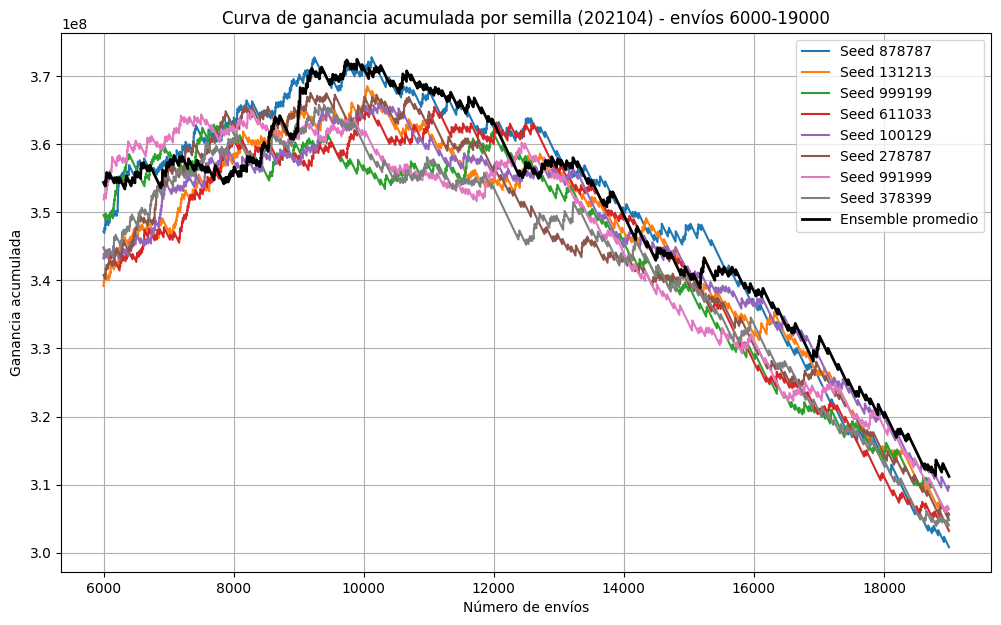

In [21]:
import matplotlib.pyplot as plt
import copy

SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar

# --------------------------
# 1️⃣ Preparar datasets
# --------------------------
dataset_train_eval = df[df["foto_mes"].isin([202101, 202102, 202103])].copy()
X_train_eval = dataset_train_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_eval = np.where(dataset_train_eval["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

dataset_test_eval = df[df["foto_mes"] == 202104].copy()
X_test_eval = dataset_test_eval[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)

# --------------------------
# 2️⃣ Preparar parámetros finales
# --------------------------
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

# --------------------------
# 3️⃣ Entrenamiento ensemble
# --------------------------
modelos_eval = []
preds_ensemble_eval = np.zeros(len(dataset_test_eval))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed

    print(f"Entrenando modelo con seed = {seed} (evaluación 202104)")
    model = lgb.train(params_seed, lgb.Dataset(X_train_eval, label=y_train_eval))
    modelos_eval.append(model)

    preds_ensemble_eval += model.predict(X_test_eval) / len(SEEDS)

dataset_test_eval["prob_mean"] = preds_ensemble_eval

# --------------------------
# 4️⃣ Curva de ganancia por semilla y ensemble (rango limitado)
# --------------------------
plt.figure(figsize=(12,7))

for i, model in enumerate(modelos_eval):
    preds = model.predict(X_test_eval)
    df_pred = dataset_test_eval[["numero_de_cliente", "clase_ternaria"]].copy()
    df_pred["pred"] = preds
    df_pred = df_pred.sort_values("pred", ascending=False).reset_index(drop=True)
    
    # limitar envíos al máximo
    df_pred = df_pred.iloc[:MAX_ENVIOS]  

    df_pred["ganancia"] = np.where(df_pred["clase_ternaria"]=="BAJA+2", 780000, -20000)
    df_pred["ganancia_acum"] = df_pred["ganancia"].cumsum()

    # seleccionar solo el rango deseado
    df_rango = df_pred.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]  # indices 0-based

    # print del total y por clase
    total_ganancia = df_rango["ganancia"].sum()
    publico_ganancia = df_rango[df_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
    privado_ganancia = df_rango[df_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

    print(f"\nSeed {SEEDS[i]} (envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}):")
    print(f"Total ganancia: {total_ganancia}")
    print(f"Público (BAJA+2): {publico_ganancia}")
    print(f"Privado (otros): {privado_ganancia}")

    plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_rango["ganancia_acum"], label=f"Seed {SEEDS[i]}")

# Ensemble promedio
df_ensemble = dataset_test_eval.copy()
preds_ensemble = np.zeros(len(df_ensemble))
for model in modelos_eval:
    preds_ensemble += model.predict(X_test_eval) / len(modelos_eval)
df_ensemble["prob_mean"] = preds_ensemble

df_ensemble = df_ensemble.sort_values("prob_mean", ascending=False).reset_index(drop=True)
df_ensemble = df_ensemble.iloc[:MAX_ENVIOS]
df_ensemble["ganancia"] = np.where(df_ensemble["clase_ternaria"]=="BAJA+2", 780000, -20000)
df_ensemble["ganancia_acum"] = df_ensemble["ganancia"].cumsum()

df_ensemble_rango = df_ensemble.iloc[RANGO_ENV[0]-1:RANGO_ENV[1]]
total_ganancia = df_ensemble_rango["ganancia"].sum()
publico_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]=="BAJA+2"]["ganancia"].sum()
privado_ganancia = df_ensemble_rango[df_ensemble_rango["clase_ternaria"]!="BAJA+2"]["ganancia"].sum()

print("\nEnsemble promedio (envíos 6000-19000):")
print(f"Total ganancia: {total_ganancia}")
print(f"Público (BAJA+2): {publico_ganancia}")
print(f"Privado (otros): {privado_ganancia}")

plt.plot(np.arange(RANGO_ENV[0], RANGO_ENV[1]+1), df_ensemble_rango["ganancia_acum"],
         color="black", linewidth=2, label="Ensemble promedio")

plt.xlabel("Número de envíos")
plt.ylabel("Ganancia acumulada")
plt.title(f"Curva de ganancia acumulada por semilla (202104) - envíos {RANGO_ENV[0]}-{RANGO_ENV[1]}")
plt.legend()
plt.grid(True)
plt.show()


#### Analizo las features más importantes y las guardo en un archivo 

In [22]:
# 1️⃣ Obtener importancia promedio de variables
importancias = [m.feature_importance(importance_type="gain") for m in modelos_eval]
tb_importancia = np.mean(importancias, axis=0)  # promedio entre las 5 seeds

nombres_columnas = dataset_train_eval[campos_buenos].columns
df_importancia = pd.DataFrame({
    "Feature": nombres_columnas,
    "Importance": tb_importancia
}).sort_values(by="Importance", ascending=False)

# 2️⃣ Guardar a archivo
archivo_importancia = "impo_nuevo_n.txt"
df_importancia.to_csv(archivo_importancia, sep="\t", index=False)

# 3️⃣ Mostrar las primeras filas
print(df_importancia.head())


                           Feature    Importance
645                   ctrx_quarter  31869.576841
836                 mcuentas_saldo   6169.344902
535                   cpayroll_trx   4215.230492
1001  mprestamos_personales_ranked   3837.740823
956           mpayroll_norm_ranked   3545.992000


#### Armo el dataset para predecir 202106

In [ ]:
# --------------------------
# 1️⃣ Preparar dataset de entrenamiento completo (202101-202104)
# --------------------------
dataset_train_final = df[df["foto_mes"].isin([202101, 202102, 202103, 202104])].copy()
X_train_final = dataset_train_final[campos_buenos].apply(pd.to_numeric, errors="coerce").fillna(0)
y_train_final = np.where(dataset_train_final["clase_ternaria"].isin(["BAJA+1","BAJA+2"]), 1, 0)

# Dataset futuro 202106
# Dataset futuro 202106
df_future_final = df[df["foto_mes"] == 202106].copy()
X_future_final = df_future_final[campos_buenos]  # sin fillna ni convertir a float32
# si hay categóricas, convertir igual que en X_train_final:
for col in X_future_final.select_dtypes(include=['object']).columns:
    X_future_final[col] = X_future_final[col].astype('category').cat.codes

# Predicciones ensemble
preds_ensemble_final = np.zeros(len(df_future_final))



NameError: name 'SEEDS' is not defined

#### Predigo junio con las 8 semillas ensambladas para generar los .csv con los envíos

In [ ]:


SEEDS = [878787, 131213, 999199, 611033, 100129,278787,991999,378399]
MAX_ENVIOS = 40000  # límite de envíos
RANGO_ENV = (6000, 19000)  # rango que queremos visualizar
import copy
param_final = PARAM["lgbm"]["param_fijos"].copy()
param_final.update(PARAM["out"]["lgbm"]["mejores_hiperparametros"])
param_normalizado = copy.deepcopy(param_final)
param_normalizado["min_data_in_leaf"] = int(round(
    param_final["min_data_in_leaf"] / PARAM["trainingstrategy"]["undersampling"]
))

for seed in SEEDS:
    params_seed = copy.deepcopy(param_normalizado)
    params_seed["seed"] = seed
    model = lgb.train(params_seed, lgb.Dataset(X_train_final, label=y_train_final))
    preds_ensemble_final += model.predict(X_future_final) / len(SEEDS)

# Guardo en DataFrame
tb_prediccion_final = df_future_final[["numero_de_cliente"]].copy()
tb_prediccion_final["Predicted_prob"] = preds_ensemble_final

# Ordeno por probabilidad descendente
tb_prediccion_final = tb_prediccion_final.sort_values(by="Predicted_prob", ascending=False).reset_index(drop=True)

import os
os.makedirs("kaggle", exist_ok=True)

for envios in PARAM["cortes"]:
    tb_prediccion_final["Predicted"] = 0
    tb_prediccion_final.loc[:envios-1, "Predicted"] = 1
    archivo_kaggle = f"./kaggle/KA{PARAM['experimento']}_{envios}.csv"
    tb_prediccion_final[["numero_de_cliente", "Predicted"]].to_csv(archivo_kaggle, index=False, sep=",")


##### --- aca termina ---